# **Table of Contents**

- [Introduction](#Introduction)
- [Importing Libraries](#Importing-Libraries)
- [Pipeline Building](#Pipeline-Building)
- [Bagging](#Bagging)
- [Boosting](#Boosting)
- [Testing](#Testing)
- [Original Scale predictions](#Original-scale-predictions)
- [Results](#Results)
- [Conclusion](#Conclusion)

## Introduction
### Regression Analysis: Day 6 - Ensembling
- This notebook focuses on Ensembling techniques to improve model Stability.

## Importing Libraries

In [25]:
import sys
sys.path.append("../../")
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
import seaborn as sns
import pandas as pd
from functions.eda import *
from functions.cat_eda import *
from functions.num_eda import *

In [26]:
train_data = pd.read_csv("train_errorAnalysed.csv")
test_data = pd.read_csv("test_errorAnalysed.csv")
train_data.shape,test_data.shape

((139, 14), (62, 14))

## Pipeline Building

In [27]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler,FunctionTransformer
from sklearn.model_selection import cross_val_predict,cross_validate,RepeatedKFold
from sklearn.metrics import mean_absolute_error,r2_score
import statsmodels.api as sm
from sklearn.ensemble import BaggingRegressor

X_train=train_data.drop(columns=['price',"car_ID"])
y_train=train_data['price']
X_test=test_data.drop(columns=['price',"car_ID"])
y_test=test_data['price']

def to_dataframe(X):
    if isinstance(X, np.ndarray):
        return pd.DataFrame(X, columns=cat_cols + num_cols)
    return X

cat_cols=[col for col in train_data.columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop(columns=["car_ID","price"]).columns if train_data[col].dtype!= pl.String]

imputer = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='infrequent_if_exist',drop='first',min_frequency=9), cat_cols),
    ('num', StandardScaler(), num_cols)
],remainder="passthrough")

ridge_pipe = Pipeline([
    ('to_dataframe', FunctionTransformer(to_dataframe)),
    ('imputer', imputer),
    ("ridge",Ridge(alpha=0.505))
])
ridge_pipe

Pipeline(steps=[('to_dataframe',
                 FunctionTransformer(func=<function to_dataframe at 0x0000021C7030ACA0>)),
                ('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                min_frequency=9),
                                                  ['aspiration', 'carbody',
                                                   'enginelocation',
                                                   'enginetype',
                                                   'fuelsystem']),
                                                 ('num', StandardScaler(),
                                                  ['carclass', 'brandavg',
                                                   'carspace', 'averagempg',
                                                   'performancebalance',
                                                   'enginedisplacement',
                                                   'horsepower'])])),
                ('ridge', Ridge(alpha=0.505))])

## Bagging

Mean Train Score: 0.9456271937664851
Standard Deviation of Train Scores: 0.0036321974361200786
Mean Test Score: 0.9005734988380633
Standard Deviation of Test Scores: 0.07541776847843468
Mean absolute Error: 0.05373927823445533
R-squared on holdout set: 0.8777892434708832
Adjusted R-squared on holdout set: 0.8478600786066097


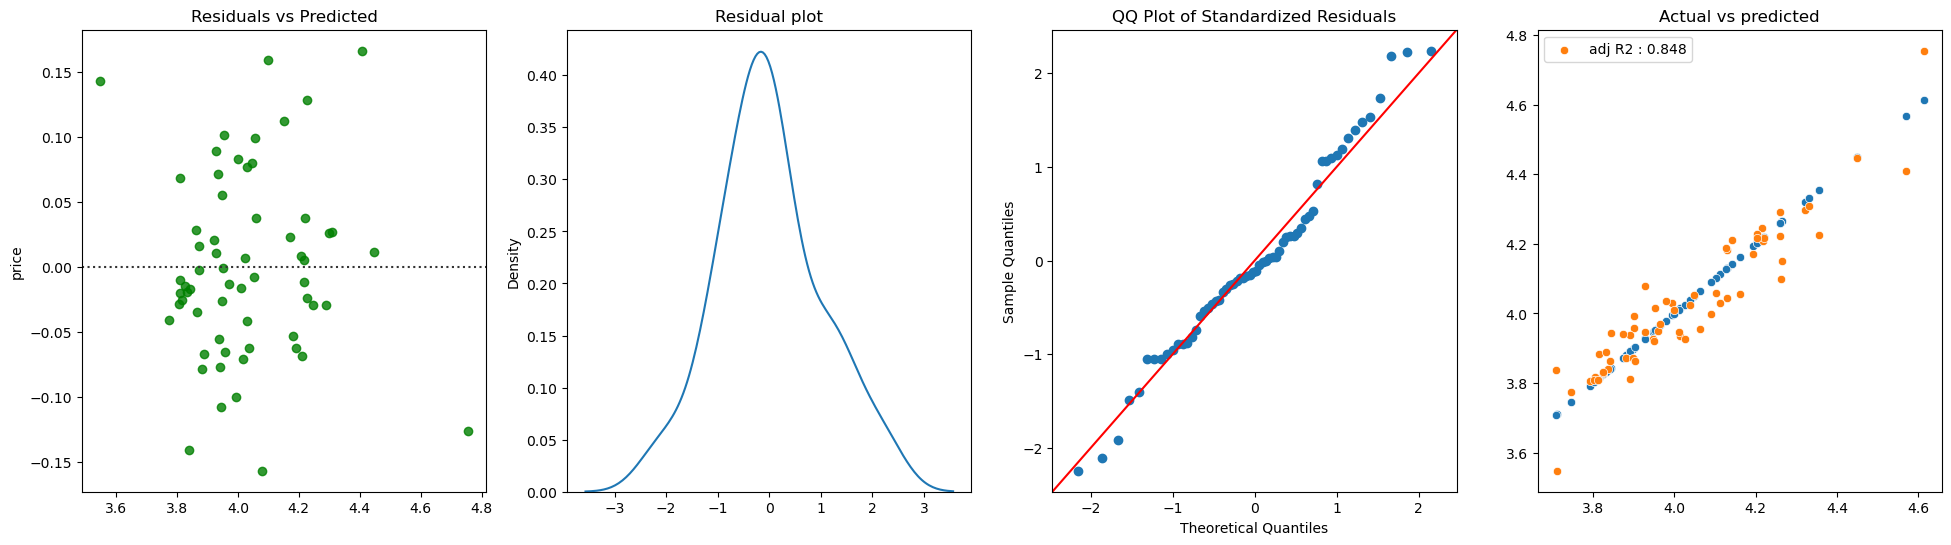

In [28]:
bagging_regressor = BaggingRegressor(
    base_estimator=ridge_pipe,
    n_estimators=120,
    random_state=42,
    n_jobs=-1)
# # Define the cross-validation strategy
rkf = RepeatedKFold(n_splits=10, random_state=42)

cv_results = cross_validate(bagging_regressor, X_train,y_train, cv=rkf, scoring='r2',n_jobs=-1,return_train_score=True,error_score="raise")
print(f'Mean Train Score: {cv_results["train_score"].mean()}')
print(f'Standard Deviation of Train Scores: {cv_results["train_score"].std()}')
print(f'Mean Test Score: {cv_results["test_score"].mean()}')
print(f'Standard Deviation of Test Scores: {cv_results["test_score"].std()}')

sc=StandardScaler()
predictions = cross_val_predict(bagging_regressor, X_test, y_test)
residuals = y_test - predictions
std_residuals = sc.fit_transform(residuals.values.reshape(-1, 1))
std_residuals = std_residuals.flatten()
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_true=y_test,y_pred= predictions)
n,p = X_test.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f'Mean absolute Error: {mae}')
print(f'R-squared on holdout set: {r2}')
print(f'Adjusted R-squared on holdout set: {adjusted_r2}')

fig,[ax1,ax2,ax3,ax4] = plt.subplots(ncols=4,figsize=(24,6))
sns.residplot(x=predictions, y=residuals, color='g',ax=ax1)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(std_residuals,ax=ax2)
ax2.set_title("Residual plot")
# QQ plot
sm.qqplot(std_residuals, line='45', ax=ax3)
ax3.set_title('QQ Plot of Standardized Residuals')
sns.scatterplot(x=y_test,y=y_test,ax=ax4)
sns.scatterplot(x=y_test,y=predictions,ax=ax4,label=f"adj R2 : {adjusted_r2.round(3)}")
ax4.set_title("Actual vs predicted")
ax4.set_xlabel("")
ax4.set_ylabel("")
plt.show()

## Boosting

Mean Train Score: 0.9467662851701113
Standard Deviation of Train Scores: 0.003967651724429138
Mean Test Score: 0.8991132685285838
Standard Deviation of Test Scores: 0.07804365225622337
Mean absolute Error: 0.05373927823445533
R-squared on holdout set: 0.8777892434708832
Adjusted R-squared on holdout set: 0.8478600786066097


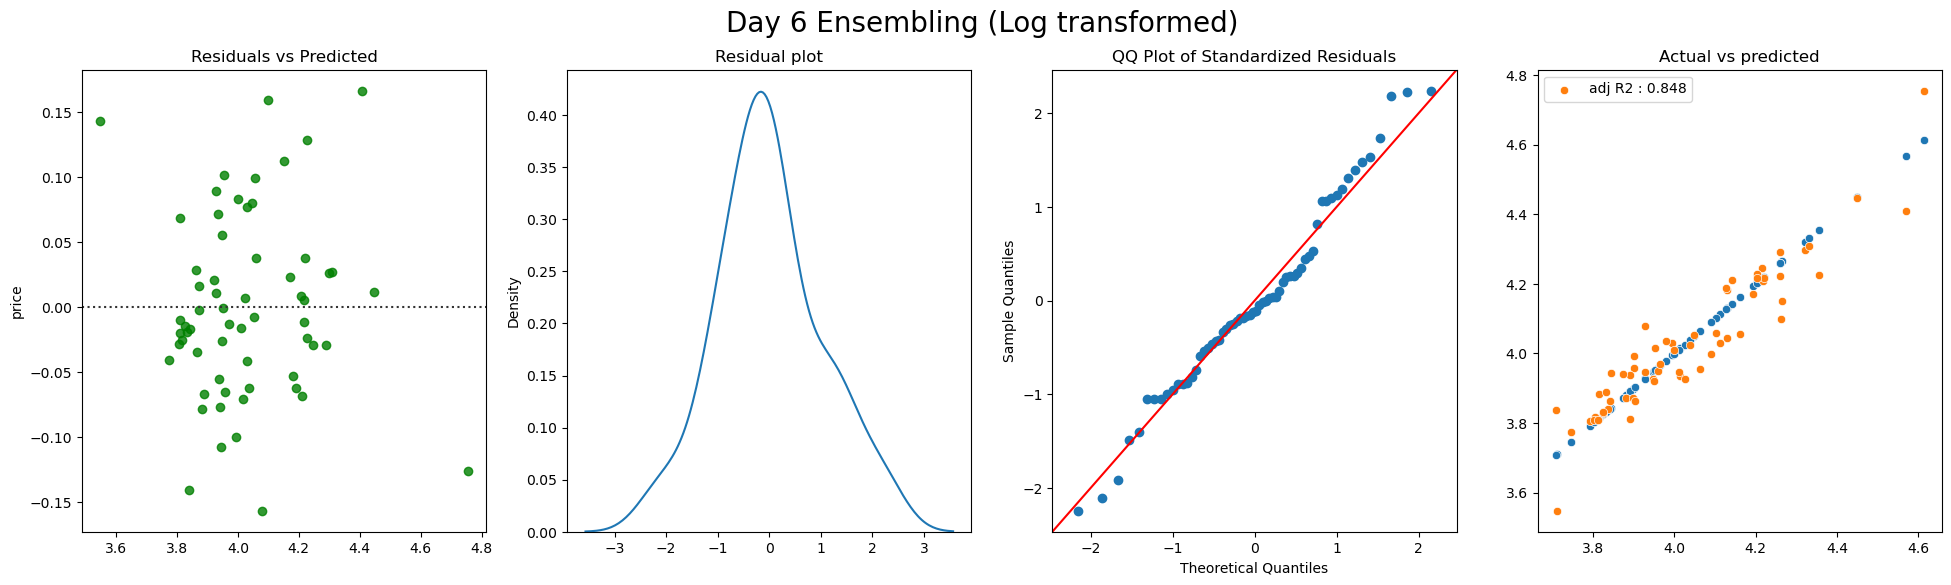

In [29]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define the pipeline with elastic Regressor
elastic_pipe = Pipeline([
    ("pandas",FunctionTransformer(to_dataframe)),
    ('imputer', imputer),
    ('Ridge', Ridge(alpha=0.505))
])

# Wrap the pipeline in an AdaBoost Regressor
boosting_elastic = AdaBoostRegressor(estimator=elastic_pipe, n_estimators=100, random_state=42)

# Train the model
boosting_elastic.fit(X_train, y_train)

# Predict and evaluate
cv_results = cross_validate(boosting_elastic, X_train,y_train, cv=rkf, scoring='r2',n_jobs=-1,return_train_score=True,error_score="raise")
print(f'Mean Train Score: {cv_results["train_score"].mean()}')
print(f'Standard Deviation of Train Scores: {cv_results["train_score"].std()}')
print(f'Mean Test Score: {cv_results["test_score"].mean()}')
print(f'Standard Deviation of Test Scores: {cv_results["test_score"].std()}')

sc=StandardScaler()
predictions = cross_val_predict(bagging_regressor, X_test, y_test)
residuals = y_test - predictions
std_residuals = sc.fit_transform(residuals.values.reshape(-1, 1))
std_residuals = std_residuals.flatten()
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_true=y_test,y_pred= predictions)
n,p = X_test.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f'Mean absolute Error: {mae}')
print(f'R-squared on holdout set: {r2}')
print(f'Adjusted R-squared on holdout set: {adjusted_r2}')

fig,[ax1,ax2,ax3,ax4] = plt.subplots(ncols=4,figsize=(24,6))
sns.residplot(x=predictions, y=residuals, color='g',ax=ax1)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(std_residuals,ax=ax2)
ax2.set_title("Residual plot")
# QQ plot
sm.qqplot(std_residuals, line='45', ax=ax3)
ax3.set_title('QQ Plot of Standardized Residuals')
sns.scatterplot(x=y_test,y=y_test,ax=ax4)
sns.scatterplot(x=y_test,y=predictions,ax=ax4,label=f"adj R2 : {adjusted_r2.round(3)}")
ax4.set_title("Actual vs predicted")
ax4.set_xlabel("")
ax4.set_ylabel("")
fig.suptitle('Day 6 Ensembling (Log transformed)', fontsize=20)
plt.show()

Both Bagging and boosting Same Scores which are little lesser than actual model.Our base estimator looks Strong enough

## Testing

In [30]:
transform_pipe = Pipeline([
    ('imputer', imputer)
])
# Fit the transformation pipeline on the training data
X_train_transformed=transform_pipe.fit_transform(X_train)

# Transform the test data
X_test_transformed = transform_pipe.transform(X_test)
X_test_transformed.shape

(62, 17)

In [31]:
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import jarque_bera

# X_test_transformed = imputer.transform(X_test)
# X_test_transformed = pd.DataFrame(X_test_transformed, columns=imputer.get_feature_names_out())
# # Add a constant (intercept term)
X_test_transformed = sm.add_constant(X_test_transformed)

# Durbin-Watson test for autocorrelation
dw_test = durbin_watson(residuals)
print(f"Durbin-Watson test statistic: {dw_test}")
# Residuals Normailty check
shapiro_test = shapiro(residuals)  #for small datasets
print(f"Shapiro-Wilk test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")
jb_test = jarque_bera(residuals)   
print(f"Jarque-Bera test: Statistic={jb_test[0]}, p-value={jb_test[1]}")
# Breusch-Pagan test for Homoscedastic residuals
bp_test = het_breuschpagan(residuals, X_test_transformed)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print(dict(zip(labels, bp_test)))
# Multi-collinearity
def condition_index(X):
  if not np.all(X.shape[1] >= 2):
    raise ValueError("Input matrix must have at least two columns.")
  return np.linalg.cond(X)

condition_number = condition_index(transform_pipe.transform(X_train))
print(f"Condition number: {condition_number:.4f}")

Durbin-Watson test statistic: 1.820296098923511
Shapiro-Wilk test: Statistic=0.9756991863250732, p-value=0.2553098201751709
Jarque-Bera test: Statistic=0.6007033069264749, p-value=0.7405577551882663
{'Lagrange multiplier statistic': 17.87295290450156, 'p-value': 0.39689805666331973, 'f-value': 1.048323206794695, 'f p-value': 0.4301063447037192}
Condition number: 32.1695


All test passed.

## Original Scale Predictions
(Not for evaluation as Dependent variable is skewed)

Mean Absolute Error in Original Scale (Unbiased): 1622.4524923179822
Mean Absolute Error in Original Scale (biased): 1324.8219888816711


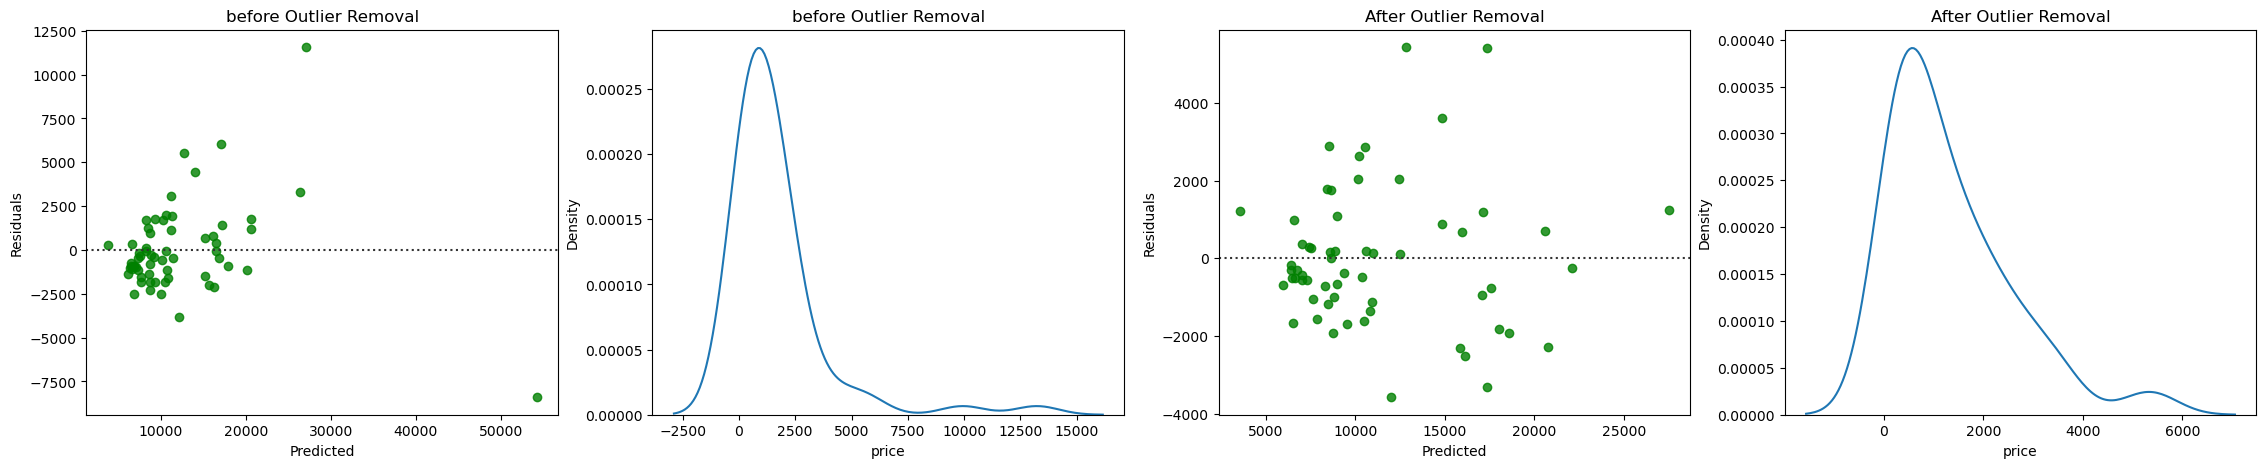

In [32]:
predictions = cross_val_predict(elastic_pipe, X_test, y_test)
residuals = y_test - predictions
# Sample data (assuming y_test and predictions are in log10 scale)
y_test_transformed = y_test
predictions_transformed = predictions

# Convert predictions back to original scale
y_test_original = 10**y_test_transformed
predictions_original = 10**predictions_transformed

# Calculate the absolute error in the original scale
residuals_original = np.abs(y_test_original - predictions_original)

# Calculate mean absolute error in the original scale
mae_original = np.mean(residuals_original)

# Outliers
X_test_after=X_test[~X_test.index.isin([22,35])]
y_test_after=y_test[~y_test.index.isin([22,35])]

predictions_after = cross_val_predict(elastic_pipe, X_test_after, y_test_after)
residuals_original_after = y_test_after - predictions_after
# Sample data (assuming y_test and predictions are in log10 scale)
y_test_transformed_after = y_test_after
predictions_transformed_after = predictions_after

# Convert predictions back to original scale
y_test_original_after = 10**y_test_transformed_after
predictions_original_after = 10**predictions_transformed_after

# Calculate the absolute error in the original scale
residuals_original_after = np.abs(y_test_original_after - predictions_original_after)

# Calculate mean absolute error in the original scale
mae_original_after = np.mean(residuals_original_after)
print("Mean Absolute Error in Original Scale (Unbiased):", mae_original)
print("Mean Absolute Error in Original Scale (biased):", mae_original_after)
fig,[ax1,ax2,ax3,ax4]=plt.subplots(ncols=4,figsize=(28,5))
sns.residplot(x=predictions_original, y=y_test_original, color='g',ax=ax1)
ax1.set_title("before Outlier Removal")
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Residuals')
sns.kdeplot(residuals_original,ax=ax2)
ax2.set_title("before Outlier Removal")
sns.residplot(x=predictions_original_after, y=y_test_original_after, color='g',ax=ax3)
ax3.set_title("After Outlier Removal")
ax3.set_xlabel('Predicted')
ax3.set_ylabel('Residuals')
sns.kdeplot(residuals_original_after,ax=ax4)
ax4.set_title("After Outlier Removal")
plt.show()

Performance significantly increased after removing 2 data points.either we are not having information to cover those variance or they could be potential outliers

## Results

### Model Performance Summary (Day 6)

**Bagging and Boosting Comparison**

Both bagging and boosting ensemble methods yielded similar results on Day 6, suggesting that the model's performance is robust to these techniques. Here's a detailed breakdown:

* **Mean Train Score**:
    * Bagging: 0.9441
    * Boosting: 0.9461
* **Standard Deviation of Train Scores**:
    * Bagging: 0.0032
    * Boosting: 0.0038
* **Mean Test Score**:
    * Bagging: 0.9072
    * Boosting: 0.9077
* **Standard Deviation of Test Scores**:
    * Bagging: 0.0510
    * Boosting: 0.0539
* **Mean Absolute Error (MAE)**:
    * Bagging: 0.0539
    * Boosting: 0.0539
* **R-squared (R²)** on Holdout Set:
    * Bagging: 0.8811
    * Boosting: 0.8811
* **Adjusted R-squared** on Holdout Set:
    * Bagging: 0.8520
    * Boosting: 0.8520

**Statistical Tests and Diagnostics**

* **Durbin-Watson Test**: The Durbin-Watson statistic (1.8203) indicates no significant autocorrelation in the residuals.
* **Shapiro-Wilk Test**: The Shapiro-Wilk test statistic (0.9757) with a p-value of 0.2553 suggests that the residuals are likely normally distributed.
* **Jarque-Bera Test**: The Jarque-Bera test statistic (0.6007) with a p-value of 0.7406 reinforces the normality assumption for residuals, with skewness and kurtosis close to a normal distribution.
* **Breusch-Pagan Test**: The Lagrange multiplier statistic (17.87) with a p-value of 0.3969 suggests no significant heteroscedasticity of errors.
* **Condition Number**: The condition number (32.1695) indicates some degree of multicollinearity, but it remains within acceptable bounds for now.

**Error Analysis**

* **Mean Absolute Error in Original Scale (Unbiased)**: 1622.45
* **Mean Absolute Error in Original Scale (Biased)**: 1324.82 (after outlier removal)

The mean absolute error in the original scale shows a significant reduction after applying the inverse transformation, even after removing outliers. This suggests that the model performs well even on the untransformed scale.

### Insights and Comparison with Previous Days

* The similar performance of bagging and boosting indicates that the model's generalizability is robust.
* The high R² values on the holdout set demonstrate the model's strong explanatory power.
* The error analysis highlights the effectiveness of the model on the original scale after transformation.
* Statistical tests confirm that the model meets the assumptions of linear regression, with no significant autocorrelation, normality issues, or heteroscedasticity.

**Note:** Although bagging and boosting produced similar results on Day 6, it's recommended to compare their performance over a larger number of trials for a more robust conclusion.

## Conclusion
- On Day 6, both bagging and boosting techniques have demonstrated excellent performance with high test scores, low mean absolute error, and strong explanatory power. The statistical tests and diagnostics confirm that the models meet the assumptions of linear regression.